In [1]:
from datetime import datetime
from datetime import timedelta
import shapefile
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from pymongo import MongoClient
import os
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn import tree
%matplotlib inline

In [2]:
start=datetime(2015,3,1,0)
end=datetime(2015,5,1,0)
timestep=3600
n_timeslots=int((end-start).total_seconds()/timestep+1)

In [3]:
accidents=np.zeros(n_timeslots)
inf=open('features_dataset/accidents_by_cell_1hour_day','r')
for line in inf:
    line=line.split(',')
    line[-1]=line[-1][:-1]
    if line[-1]!='accidents':
        t=datetime.strptime(line[1],'%Y-%m-%d %H:%M:%S')
        v=float(line[4])
        accidents[int(((t-start).total_seconds())/timestep)]+=v

In [5]:
h=3
accidents3=np.zeros(len(accidents)/h)
k=0
j=0
while j<len(accidents)-h:
        accidents3[k]=sum(accidents[j:j+h])
        k+=1
        j+=h

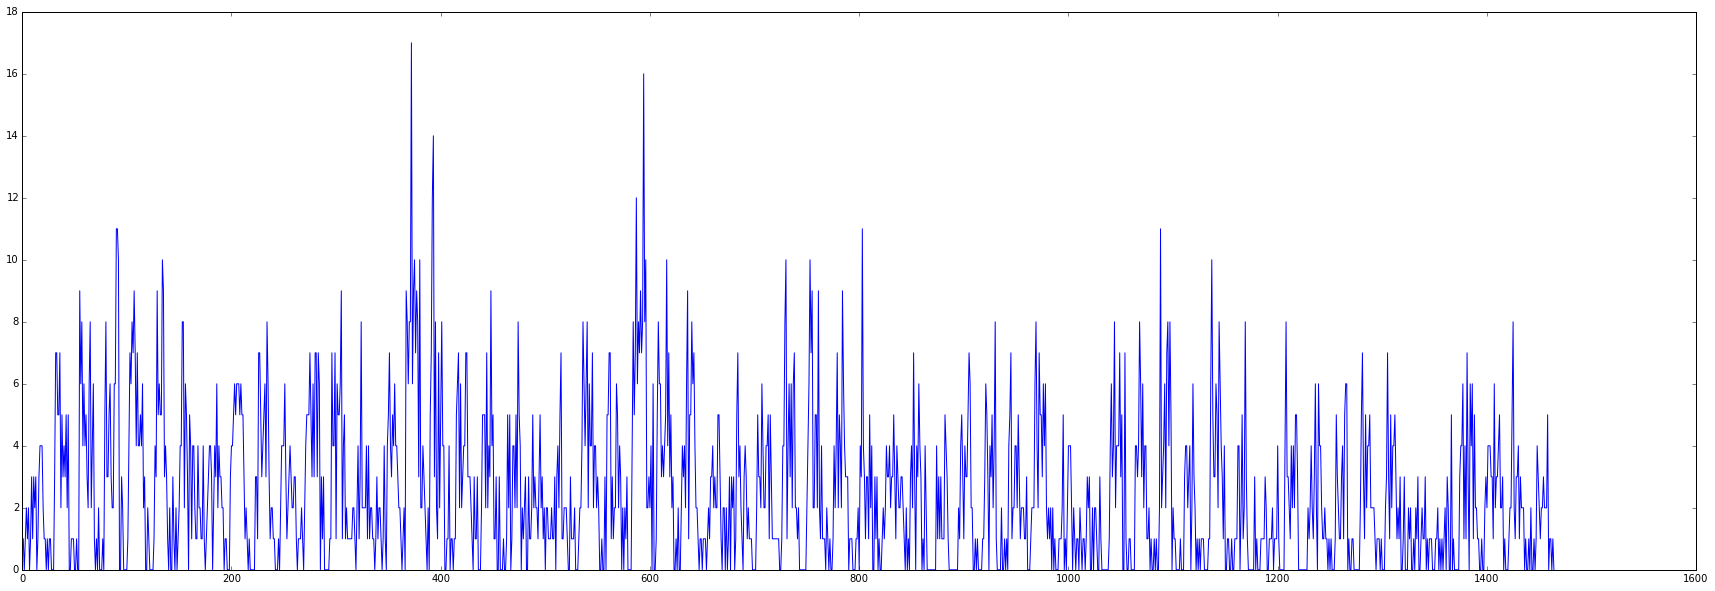

In [6]:
plt.figure(figsize=(30,10))
plt.plot(accidents)
plt.show()

In [7]:
accidents3[10]

10.0

In [20]:
accidents[30:33]

array([ 0.,  3.,  7.])

In [21]:
accidents3[10]

10.0

In [3]:
telco=np.zeros((4,n_timeslots))
dbs=['call_in_roma','call_out_roma','sms_in_roma','sms_out_roma']
coll=['callIn','callOut','smsIn','smsOut']
for i in range(len(dbs)):
    cl=MongoClient()
    db=cl[dbs[i]]
    cur=db[coll[i]].find()
    for c in cur:
        t=datetime.fromtimestamp(c['time_interval'])
        if i<2:
            v=c['n_of_calls']
        else:
            v=c['n_of_sms']
        telco[i,int(((t-start).total_seconds())/timestep)]+=v
    print dbs[i], 'ok'
    cl.close()

NameError: name 'n_timeslots' is not defined

In [34]:

telco=np.zeros((4,n_timeslots))
files=['features_dataset/callIn','features_dataset/callOut','features_dataset/smsIn','features_dataset/smsOut']
for i in range(len(files)):
    timez=[]
    f=open(files[i],'r')
    for line in f:
        line=line.split(',')
        t=datetime.strptime(line[0],'%Y-%m-%d %H:%M:%S')
        telco[i,int(((t-start).total_seconds())/timestep)]=float(line[1])
        timez.append(t)
timez=np.array(timez)

In [35]:
len(timez)

1465

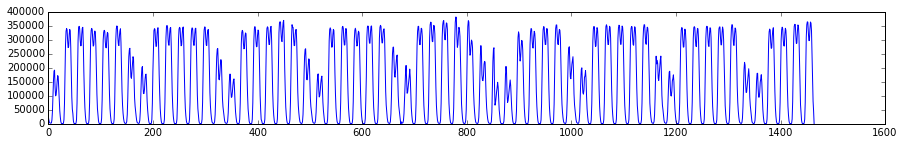

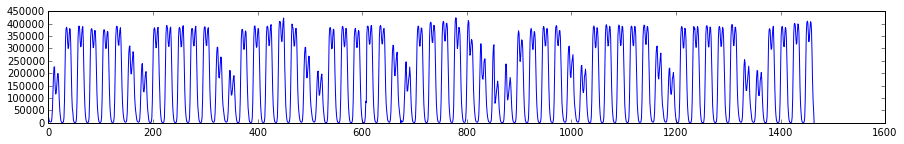

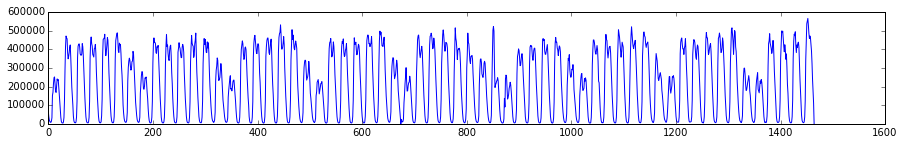

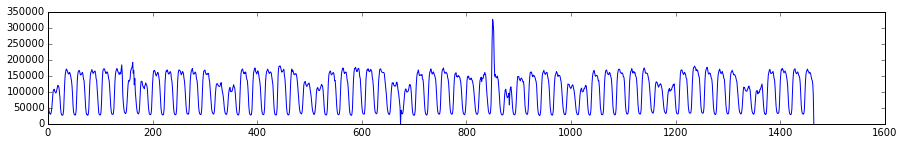

In [9]:
for t in telco:
    plt.figure(figsize=(15,2))
    plt.plot(t)
    plt.show()

In [5]:
traffic=np.zeros(n_timeslots)
out=open('features_dataset/total_fl_car_traffic','r')
for line in out:
    line=line.split(',')
    t=datetime.strptime(line[0],'%Y-%m-%d %H:%M:%S')
    traffic[int(((t-start).total_seconds())/timestep)]=float(line[1])
tree = ET.parse('/media/amassaro/external_2T/telecom_bigdata_2015/data/external_data/xml_incidenti_mar-apr_2015.xml')
root=tree.getroot()
child=list(root)[1]
time=[]
for j in child:
    if 'DataOraIncidente' in j.attrib.keys():
        time.append(j.attrib['DataOraIncidente'])

time=np.array([t[:10]+' '+t[11:] for t in time])
time=np.array([datetime.strptime(t,'%Y-%m-%d %H:%M:%S') for t in time])
day_time_comune=np.array([[t.weekday()+1,t.hour] for t in time])
H=np.histogram(day_time_comune[:,1],normed=True,bins=list(range(25)))

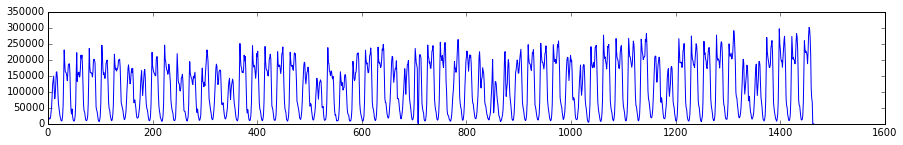

In [8]:
plt.figure(figsize=(15,2))
plt.plot(traffic)
plt.show()

In [48]:
min(twtt)

12

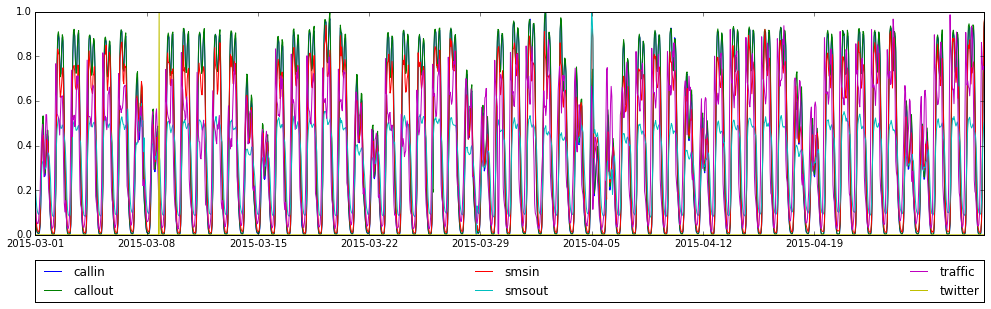

In [43]:
names=['callin','callout','smsin','smsout']
plt.figure(figsize=(17,4))
i=0
for t in telco:
    plt.plot((t-min(t))/(max(t)-min(t)),label=names[i])
    i+=1
plt.plot((traffic-min(traffic))/(max(traffic)-min(traffic)),label='traffic')
plt.plot((twtt-min(twtt))/(max(twtt)-min(twtt)),label='twitter')
plt.legend(bbox_to_anchor=(0., -.3, 1., -.1), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlim(0,1450)
philter=[k*170 for k in range(len(traffic)/170)]
plt.xticks(philter,[str(dd)[:10] for dd in timez[philter]])
plt.show()

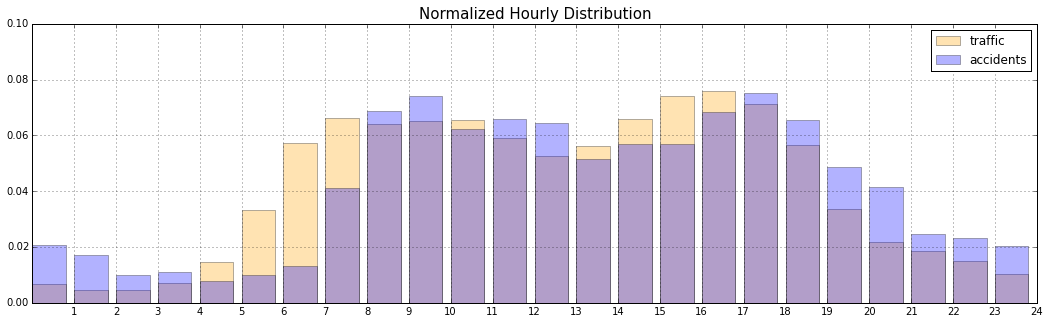

In [6]:
traffic_bars=np.zeros(24)
for i in range(len(traffic)):
    traffic_bars[i%24]+=traffic[i]
plt.bar(list(range(24)),traffic_bars/np.sum(traffic_bars),alpha=0.3,color='orange',label='traffic')
plt.xticks([i for i in range(1,25)])
plt.title('Normalized Hourly Distribution',size=15)
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_size_inches(18, 5)
plt.ylim([0,.1])
plt.bar(H[1][:-1],H[0],alpha=0.3,label='accidents')
plt.legend(loc='upper right')
plt.xticks([i for i in range(1,25)])
plt.show()

In [ ]:
start=datetime(2015,3,1,0)
timestep=3600


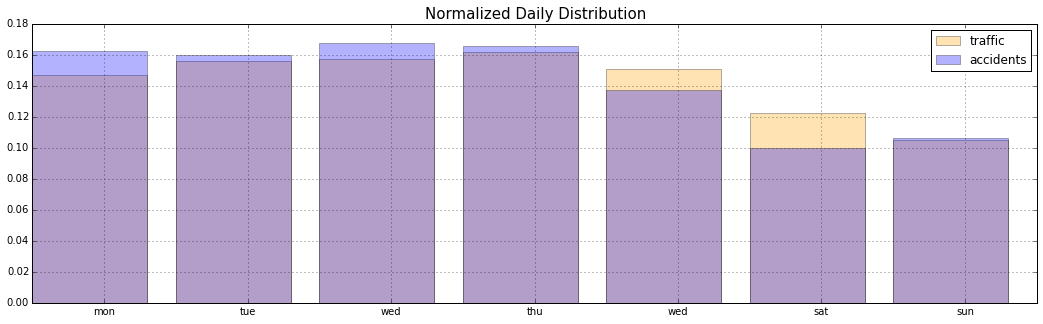

In [22]:
traffic_bars=np.zeros(7)
for i in range(len(traffic)):
    traffic_bars[(start+i*timedelta(0,timestep)).weekday()]+=traffic[i]
plt.bar(list(range(7)),traffic_bars/np.sum(traffic_bars),alpha=0.3,color='orange',label='traffic')
plt.bar(H[1][:-1]-1,H[0],alpha=0.3,label='accidents')
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],['mon','tue','wed','thu','wed','sat','sun'])
plt.title('Normalized Daily Distribution',size=15)
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_size_inches(18, 5)
#plt.ylim([0,.1])
#plt.bar(H[1][:-1],H[0],alpha=0.3,label='accidents')
#plt.legend(loc='upper right')
plt.show()  

<Container object of 7 artists>

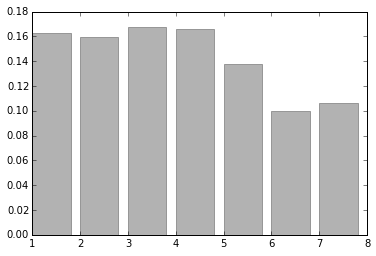

In [15]:
H=np.histogram(day_time_comune[:,0],normed=True,bins=list(range(1,9)))
plt.bar(H[1][:-1],H[0],alpha=0.3,color='black',label='incidenti')

In [96]:
weather=np.zeros(n_timeslots)-1
out=open('weather','r')
for line in out:
    if line[0]!='t':
        line=line.split(',')
        t=datetime.strptime(line[0],'%Y-%m-%d %H:%M:%S')
        weather[int(((t-start).total_seconds())/timestep)]=int(line[1])
w=list(set(weather))
Weather=np.array([w.index(ww) for ww in weather])
D=[]
i=0
while i <len(Weather):
    if Weather[i]==11:
        s=i
        c=0
        while Weather[i+c]==11:
            c+=1
        D.append([s,s+c])
        i=i+c
    else:
        i+=1
for x in D:
    if x[1]-x[0]<5:
        for i in range(x[0],x[1]):
            if i<(x[1]-x[0])/2 and x[0]>0:
                Weather[i]=Weather[[x[0]-1]]
            else:
                Weather[i]=Weather[[x[1]]]
k=w.index(-1)

Weather=np.array([Weather[i] if Weather[i]!=k else Weather[i-1] for i in range(len(Weather))])
Weather=np.array([Weather[i] if Weather[i]!=k else Weather[i+1] for i in range(len(Weather)-1)])


In [111]:
X=np.array([telco[0],telco[1],telco[2],telco[3],traffic,Weather]).T
Y=accidents

In [116]:
X=np.zeros((len(telco[0]),6))
for i in range(4):
    for j in range(len(telco[0])):
        X[j,i]=telco[i,j]
for j in range(len(traffic)):
    X[j,4]=traffic[j]
for j in range(len(Weather)):
    X[j,5]=Weather[j]

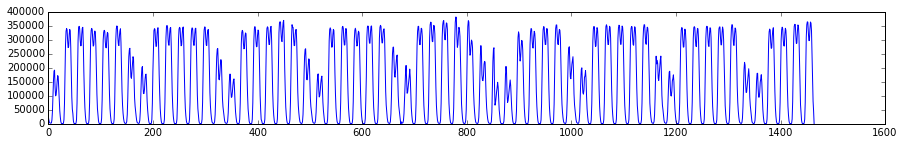

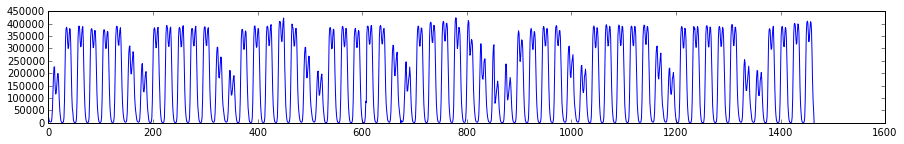

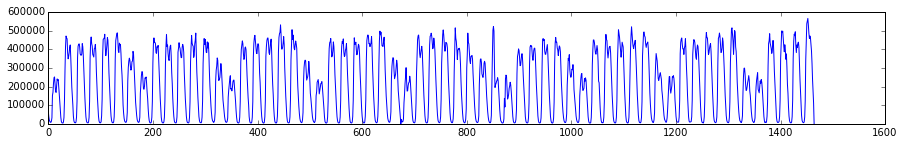

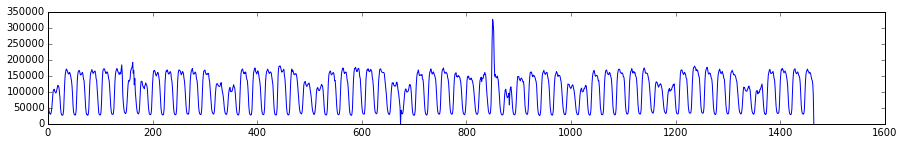

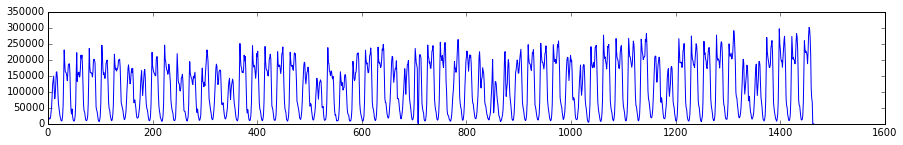

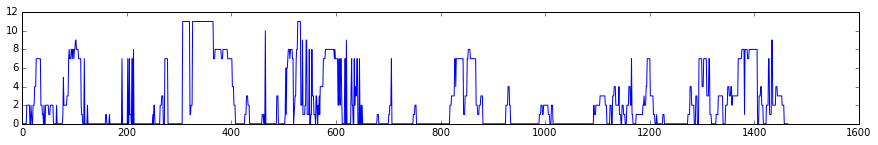

In [120]:

for i in range(6):
    plt.figure(figsize=(15,2))
    plt.plot(X[:,i])
    plt.show()

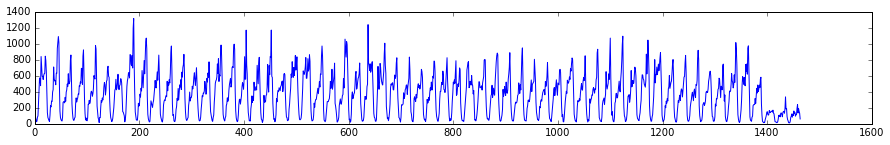

In [32]:
twtt=[]
tw=open('/home/amassaro/bigdata_telecom_15/repository/telecom_bigdata/features_dataset/twitterVolume.csv','r')
for l in tw:
    twtt.append(int(l.split(',')[1]))
twtt=np.array(twtt)
plt.figure(figsize=(15,2))
plt.plot(twtt)
plt.show()

In [54]:
len(twtt), len(telco[0])

(1464, 1465)